<a href="https://colab.research.google.com/github/adventurousAyan/AyanRepo/blob/master/Stratified_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import datetime
import gc

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(DATA_PATH + 'train_data.csv')
farm_df = pd.read_csv(DATA_PATH + 'farm_data.csv')
weather_df = pd.read_csv(DATA_PATH + 'train_weather.csv')

In [ ]:
farm_df.head()

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369


In [ ]:
train_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'yield']

In [ ]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['deidentified_location'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['deidentified_location'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['deidentified_location','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['deidentified_location','day','month'])['temp_obs'].mean(),columns=["temp_obs"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['deidentified_location','day','month'])['cloudiness'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloudiness"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['deidentified_location','day','month'])['dew_temp'].mean(),columns=["dew_temp"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['deidentified_location','day','month'])['pressure_sea_level'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['pressure_sea_level'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['deidentified_location','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['deidentified_location','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['deidentified_location','day','month'])['precipitation'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precipitation'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [ ]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['farm_area'] =  np.log1p(df['farm_area'])
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((1, 2, 3, 4), 1, inplace = True)
    df['month'].replace((5, 6, 7, 8), 2, inplace = True)
    df['month'].replace((9, 10, 11, 12), 3, inplace = True)
    
    # Remove Unused Columns
    drop = ["timestamp","pressure_sea_level", "wind_direction", "wind_speed","operations_commencing_year","num_processing_plants"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["farming_company"] = le.fit_transform(df["farming_company"])
    df["ingredient_type"] = le.fit_transform(df["ingredient_type"])
    df["farm_id"] = le.fit_transform(df["farm_id"])
    df["deidentified_location"] = le.fit_transform(df["farming_company"])
    
    return df

In [ ]:
weather_df = fill_weather_dataset(weather_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
weather_df.head()

,deidentified_location,timestamp,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,location 7369,2016-01-01 00:00:00,25.0,6.000000,0.0,20.0,1019.7,-0.173913,0.0
1,location 7369,2016-01-01 01:00:00,24.4,4.285714,70.0,21.1,1020.2,-1.000000,1.5
2,location 7369,2016-01-01 02:00:00,22.8,2.000000,0.0,21.1,1020.2,0.000000,0.0
3,location 7369,2016-01-01 03:00:00,21.1,2.000000,0.0,20.6,1020.1,0.000000,0.0
4,location 7369,2016-01-01 04:00:00,20.0,2.000000,250.0,20.0,1020.0,-1.000000,2.6


In [ ]:
train_df = reduce_mem_usage(train_df,use_float16=True)
farm_df = reduce_mem_usage(farm_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.95 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.07 MB
Decreased by -2.6%
Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 4.93 MB
Decreased by 74.4%


In [ ]:
train_df = train_df.merge(farm_df, left_on='farm_id',right_on='farm_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['deidentified_location','timestamp'],right_on=['deidentified_location','timestamp'])
del weather_df
gc.collect()

0

In [ ]:
train_df = features_engineering(train_df)

In [ ]:
train_df.head(20)

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,dew_temp,precipitation,hour,weekend,month
0,142,0,0.0,6.538798,8,8,25.0,6.0,20.0,-0.17395,0,4,1
1,1307,0,0.0,5.536138,8,8,25.0,6.0,20.0,-0.17395,0,4,1
2,376,0,0.0,6.215501,8,8,25.0,6.0,20.0,-0.17395,0,4,1
3,134,0,0.0,7.696852,8,8,25.0,6.0,20.0,-0.17395,0,4,1
4,986,0,0.0,9.290458,8,8,25.0,6.0,20.0,-0.17395,0,4,1
5,280,0,0.0,6.612342,8,8,25.0,6.0,20.0,-0.17395,0,4,1
6,1256,0,0.0,7.861499,1,1,25.0,6.0,20.0,-0.17395,0,4,1
7,591,0,0.0,9.328047,8,8,25.0,6.0,20.0,-0.17395,0,4,1
8,140,0,0.0,8.639471,8,8,25.0,6.0,20.0,-0.17395,0,4,1
9,581,0,0.0,7.827791,14,14,25.0,6.0,20.0,-0.17395,0,4,1


In [ ]:
target = np.log1p(train_df["yield"])
train_df = train_df.drop('yield', axis = 1)
gc.collect()

112

In [ ]:
categorical_features = ["farm_id", "deidentified_location", "ingredient_type", "farming_company", "weekend"]
features = [col for col in train_df.columns if col not in ['month']]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1580,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 1,
    "metric": "rmse",
}

kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=2319)
models = []
for train_index,test_index in kf.split(train_df, train_df['month']):
    train_features = train_df[features].loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = train_df[features].loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=3000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.20945	valid_1's rmse: 1.24836
[50]	training's rmse: 1.02659	valid_1's rmse: 1.09438
[75]	training's rmse: 0.955788	valid_1's rmse: 1.05677
[100]	training's rmse: 0.911095	valid_1's rmse: 1.05015
[125]	training's rmse: 0.881111	valid_1's rmse: 1.04879
[150]	training's rmse: 0.859855	valid_1's rmse: 1.05019
Early stopping, best iteration is:
[119]	training's rmse: 0.888168	valid_1's rmse: 1.04833
Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.18592	valid_1's rmse: 1.30828
[50]	training's rmse: 0.998059	valid_1's rmse: 1.1854
[75]	training's rmse: 0.928491	valid_1's rmse: 1.15809
[100]	training's rmse: 0.887759	valid_1's rmse: 1.15243
[125]	training's rmse: 0.859505	valid_1's rmse: 1.15211
[150]	training's rmse: 0.839973	valid_1's rmse: 1.15296
Early stopping, best iteration is:
[117]	training's rmse: 0.868622	valid_1's rmse: 1.15131
Training until validation scores

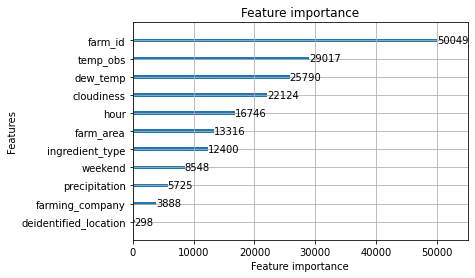

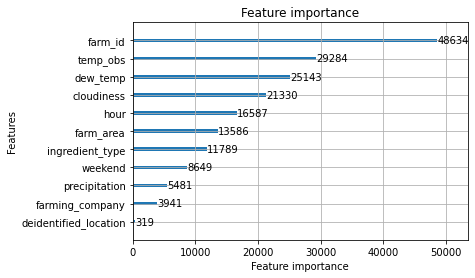

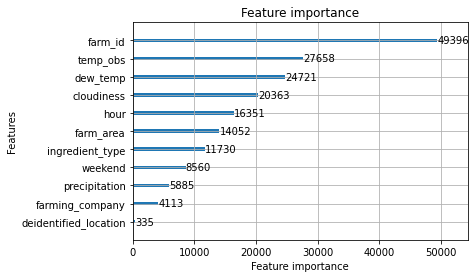

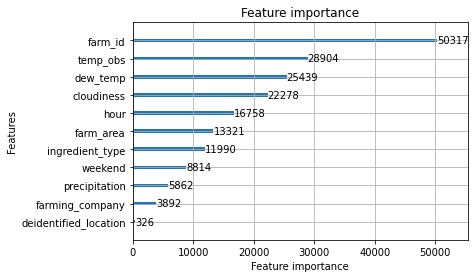

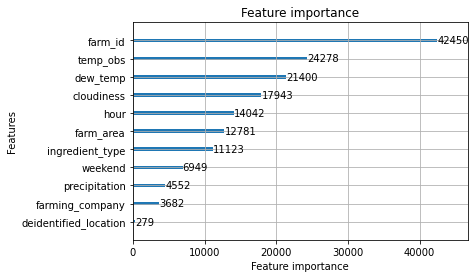

In [ ]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [ ]:
test_df = pd.read_csv(DATA_PATH + 'test_data.csv')
row_ids = test_df["id"]
test_df.drop("id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 477.19 MB
Memory usage after optimization is: 99.84 MB
Decreased by 79.1%


In [ ]:
test_df = test_df.merge(farm_df,left_on='farm_id',right_on='farm_id',how='left')
del farm_df
gc.collect()

19165

In [ ]:
weather_df = pd.read_csv(DATA_PATH + 'test_weather.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Memory usage of dataframe is 19.16 MB
Memory usage after optimization is: 8.63 MB
Decreased by 55.0%


In [ ]:
test_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'operations_commencing_year',
       'num_processing_plants', 'farm_area', 'farming_company',
       'deidentified_location'],
      dtype='object')

In [ ]:
test_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'operations_commencing_year',
       'num_processing_plants', 'farm_area', 'farming_company',
       'deidentified_location']

In [ ]:
test_df = test_df.merge(weather_df,how='left',on=['timestamp','deidentified_location'])
del weather_df
gc.collect()

150

In [ ]:
test_df = features_engineering(test_df)

In [ ]:
test_df.head(20)

,farm_id,ingredient_type,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,dew_temp,precipitation,hour,weekend,month
0,142,0,6.538798,8,8,17.799999,4.0,11.7,0.0,0,6,1
1,1307,0,5.536138,8,8,17.799999,4.0,11.7,0.0,0,6,1
2,376,0,6.215501,8,8,17.799999,4.0,11.7,0.0,0,6,1
3,134,0,7.696852,8,8,17.799999,4.0,11.7,0.0,0,6,1
4,986,0,9.290458,8,8,17.799999,4.0,11.7,0.0,0,6,1
5,280,0,6.612342,8,8,17.799999,4.0,11.7,0.0,0,6,1
6,1256,0,7.861499,1,1,17.799999,4.0,11.7,0.0,0,6,1
7,591,0,9.328047,8,8,17.799999,4.0,11.7,0.0,0,6,1
8,591,1,9.328047,8,8,17.799999,4.0,11.7,0.0,0,6,1
9,140,0,8.639471,8,8,17.799999,4.0,11.7,0.0,0,6,1


In [ ]:
results[::-1]

array([inf, inf, inf, ..., inf, inf, inf])

In [ ]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
results[:10]

array([  7.57396038,   4.11009486,   1.07568786,   8.34848464,
        15.76717207,   1.11563722,   4.98548135,  11.47607575,
       152.78890357,   8.27799158])

In [ ]:
results_df = pd.DataFrame({"id": row_ids, "yield": np.clip(results, 0, a_max=None)})
#del row_ids,results
gc.collect()
#results_df.to_csv("submission.csv", index=False)

1003

In [ ]:
results_df.head(20)

,id,yield
0,0,7.573960
1,1,4.110095
2,2,1.075688
3,3,8.348485
4,4,15.767172
5,5,1.115637
6,6,4.985481
7,7,11.476076
8,8,152.788904
9,9,8.277992


In [ ]:
test_df.head()

,farm_id,ingredient_type,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,dew_temp,precipitation,hour,weekend,month
0,142,0,6.538798,8,8,17.799999,4.0,11.7,0.0,0,6,1
1,1307,0,5.536138,8,8,17.799999,4.0,11.7,0.0,0,6,1
2,376,0,6.215501,8,8,17.799999,4.0,11.7,0.0,0,6,1
3,134,0,7.696852,8,8,17.799999,4.0,11.7,0.0,0,6,1
4,986,0,9.290458,8,8,17.799999,4.0,11.7,0.0,0,6,1


In [ ]:
test2_df = pd.read_csv(DATA_PATH + 'test_data.csv')


In [ ]:
test2_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'operations_commencing_year',
       'num_processing_plants', 'farm_area', 'farming_company',
       'deidentified_location']

ValueError: ignored

In [ ]:
farm_df = pd.read_csv(DATA_PATH + 'farm_data.csv')

In [ ]:
test2_df = test2_df.merge(farm_df,left_on='farm_id',right_on='farm_id',how='left')

In [ ]:
weather_df = pd.read_csv(DATA_PATH + 'test_weather.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Memory usage of dataframe is 19.16 MB
Memory usage after optimization is: 8.63 MB
Decreased by 55.0%


In [ ]:
test2_df.columns 

Index(['date', 'farm_id', 'ingredient_type', 'id',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],
      dtype='object')

In [ ]:
test2_df.shape

(21251760, 9)

In [ ]:
row_ids = test2_df["id"]

In [ ]:
results_df.shape

(21251760, 2)

In [ ]:
results_df[results_df.duplicated(subset='id')]

,id,yield
80,79,8.270892
210,208,10.353355
340,337,10.424942
470,466,10.401811
600,595,10.401811
...,...,...
21247756,41673770,7.263498
21247989,41674002,36.363179
21247991,41674003,1.031427
21248008,41674019,13.188204


In [ ]:
results_df.id.nunique()

20848800

In [ ]:
res_df = results_df.drop_duplicates(keep='first', subset='id')

In [ ]:
res_df.shape

(20848800, 2)

In [ ]:
res_df.to_csv(DATA_PATH + 'submission_stratified_lgbm.csv', index=False)